# Simulation-based calibration


[Simulation-based calibration](https://arxiv.org/abs/1804.06788) (SBC) is a method for visually validating Bayesian inferences. SBC is useful for detection of either misspecified models, inaccurate computation or bugs in the 
implementation of a probabilistic program. So SBC is not a validation for the inference itself, but the technical aspect of the program.


Consider a generative model:

\begin{align}
\tilde{\theta} & \sim P(\theta) \\
\tilde{y} & \sim P(y \mid \tilde{\theta}) \\
\{ \theta_1, \dots, \theta_L \} & \sim P(\theta \mid \tilde{y})
\end{align}

The rank of a prior sample $\tilde{\theta}$ in comparison to an *exact* posterior sample $\{ \theta_1, \dots, \theta_L \}$: 

\begin{align}
r(\{ \theta_1, \dots, \theta_L \}, \tilde{\theta}) = \sum_l^L \mathbb{I}(\theta_l < \tilde{\theta}) + 1
\end{align}

is a discrete-uniform random variable in $[1, L + 1 ]$ (see the original paper for a proof). Thus we can use this as a testing procedure if our inferences work.

We follow Algorithm 2 from the original paper and implement SBC in Stan.

In [318]:
library(rstan)
suppressMessages(library(tidyverse))
options(repr.plot.width = 6, repr.plot.height = 3)

SBC is essentially pretty simple. For $N$ iterations we run a while loop to create a posterior sample that has at least a target effective sample size $n_{eff}$ (which is set by us). We do so by resampling and thinning until the posterior sample for every iteration reaches the target $n_{eff}$ (within the while loop). Then we compute the rank for every parameter using the sum as defined above. That is it. If the inference worked, the ranks are uniformly distributed.

In [337]:
sbc <- function(model)
{
    ranks <- matrix(0, N, 2, dimnames = list(NULL, c("mu", "sigma")))
    for (n in seq(N))
    {    
        thin <- init_thin
        while (thin < max_thin) 
        {
          fit <- suppressWarnings(
                    sampling(model, data = list(),
                    chains = 1, iter = 2 * thin * L,
                    thin = thin, control = list(adapt_delta = 0.99), refresh = 0)
          )      
          n_eff <- summary(fit)$summary["lp__", "n_eff"]
          if (n_eff >= target_neff) break;
          thin <- 2 * thin
        }        
        ranks[n,] <- apply(rstan::extract(fit)$idsim, 2, sum) + 1
    }
    ranks
}

We start with a simple example where we set two parameters, generate data from them and then compare the posterior to these parameters. The comparison is done in the `generated quantities` block.

In [363]:
model.file <- "_models/sbc_1.stan"
cat(readLines(model.file), sep="\n")

transformed data {
	real mu_sim = 0;
	real sigma_sim = 1;

	int<lower = 0> N = 10;
	vector[N] y_sim;
	for (i in 1:N)
		y_sim[i] = normal_rng(mu_sim, sigma_sim);
}

parameters {
	real mu;
	real<lower = 0> sigma;
}

model {
	mu ~ normal(0, 1);
	sigma ~ lognormal(0, 1);
  	y_sim ~ normal(mu, sigma);
}

generated quantities {
	int idsim[2] = { mu < mu_sim, sigma < sigma_sim };
}


In [349]:
model <- stan_model(model.file)

We run the loop $50$ times and sample $100$ times. We also set some other parameters that Stan or SBC needs.

In [357]:
N <- 5000
L <- 100
init_thin <- 1
max_thin <- 64
target_neff <- .8 * L

We also define a histogram plotting method for the ranks.

In [358]:
plot_fit <- function(fit)
{
    as.data.frame(fit) %>% 
        tidyr::gather("param", "value") %>%
        ggplot(aes(value)) +
        geom_histogram(bins=30) +
        scale_y_continuous("Count") + 
        scale_x_continuous("") + 
        facet_grid(. ~ param) +
        ggthemes::theme_tufte()
}

Then we run SBC and plot the ranks.

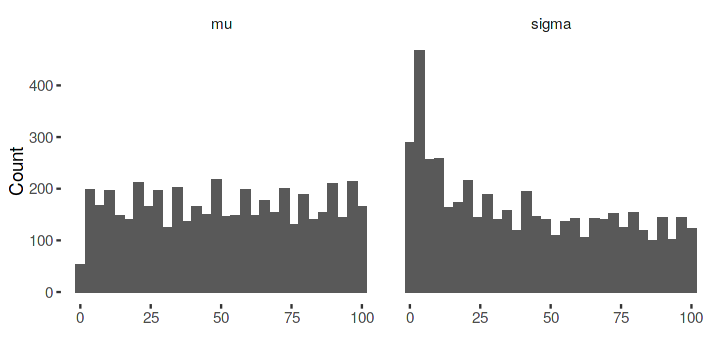

In [359]:
fit <- sbc(model)
plot_fit(fit)

Next for a pathological case, where the inferences shouldn't work.

In [362]:
model.file <- "_models/sbc_2.stan"
cat(readLines(model.file), sep="\n")

transformed data {
	real mu_sim = 0;
	real sigma_sim = 1;

	int<lower = 0> N = 10;
	vector[N] y_sim;
	for (i in 1:N)
		y_sim[i] = normal_rng(mu_sim, sigma_sim);
}

parameters {
	real mu;
	real<lower = 0> sigma;
}

model {
	mu ~ normal(0, 10);
	sigma ~ lognormal(0, 5);
	y_sim ~ student_t(10, mu, sigma);
}

generated quantities {
	int idsim[2] = { mu < mu_sim, sigma < sigma_sim };
}


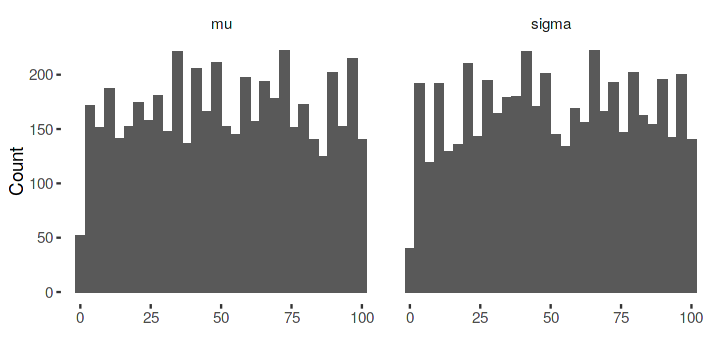

In [364]:
model <- stan_model(model.file)
fit <- sbc(model)
plot_fit(fit)

And another pathological example:

In [365]:
model.file <- "_models/sbc_3.stan"
cat(readLines(model.file), sep="\n")

transformed data {
	real mu_sim = 0;
	real sigma_sim = 1;

	int<lower = 0> N = 10;
	vector[N] y_sim;
	for (i in 1:N)
    	y_sim[i] = student_t_rng(10, mu_sim, sigma_sim);
}

parameters {
	real mu;
	real<lower = 0> sigma;
}

model {
	mu ~ normal(0, 10);
	sigma ~ lognormal(0, 5);
	y_sim ~ normal(mu, sigma);
}

generated quantities {
	int idsim[2] = { mu < mu_sim, sigma < sigma_sim };
}


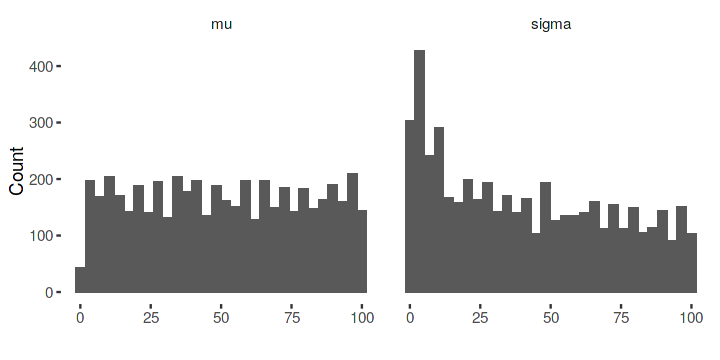

In [366]:
model <- stan_model(model.file)
fit <- sbc(model)
plot_fit(fit)